# Exploratory Data Analysis

## Imports

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
import sys
import os
import re
import swifter
import warnings
import torch
import torch.nn as nn
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
from evaluate import load
import shap
warnings.filterwarnings('ignore')

# Add the root project directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import load_raw_data #importing data loader

# Setup
#sns.set(style = "whitegrid")

### Loading NLTK

In [2]:
nltk_path = os.path.join(project_root, 'nltk_data')
nltk.data.path.insert(0, nltk_path)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# quick test
text = "This is a test sentence."
tokens = nltk.word_tokenize(text)
print(tokens)

['This', 'is', 'a', 'test', 'sentence', '.']


## Loading the dataset

In [3]:
# Load the dataset
text_df = load_raw_data()

# Preview
text_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## EDA

### General Overview

Dataset shape: (50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


<Axes: title={'center': 'Class Balance'}, xlabel='sentiment'>

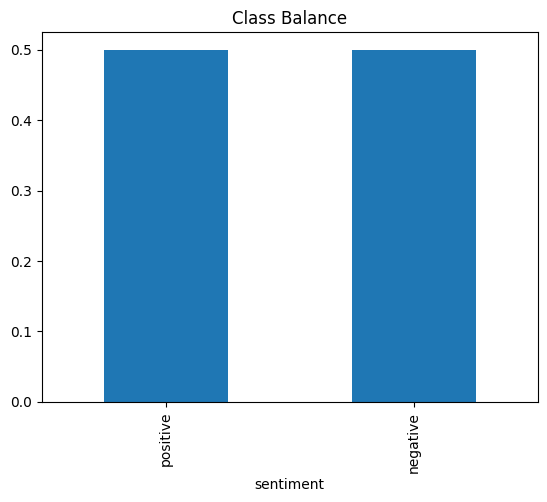

In [4]:
# Basic info
print(f"Dataset shape: {text_df.shape}")
print(text_df.info())
text_df["sentiment"].value_counts(normalize=True).plot(kind="bar", title="Class Balance")

This is a balanced dataset with no missing values. 

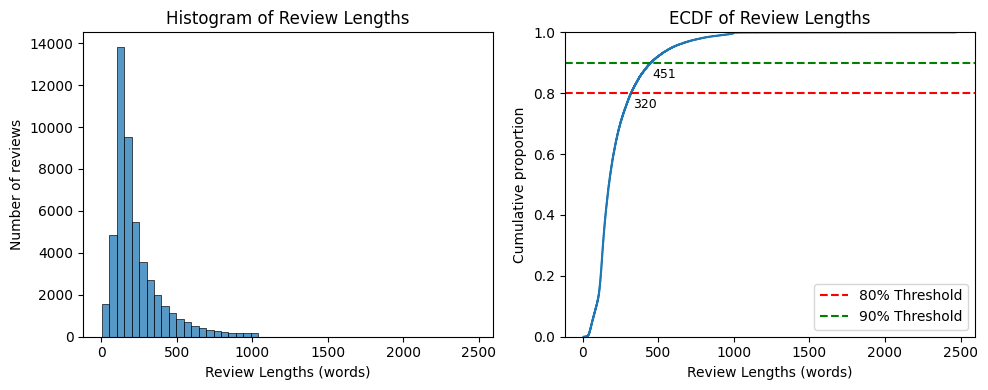

In [5]:
# Adding a column for review length
fig, axes = plt.subplots(1, 2, figsize=(10,4))
text_df["review_length"] = text_df["review"].apply(lambda x: len(str(x).split()))

# histogram of reviews lengths
sns.histplot(text_df["review_length"], bins=50, ax=axes[0])
axes[0].set_title("Histogram of Review Lengths")
axes[0].set_xlabel("Review Lengths (words)")
axes[0].set_ylabel("Number of reviews")

# ECDF plot of review lengths
sns.ecdfplot(data = text_df, x = "review_length", ax=axes[1])
axes[1].set_title("ECDF of Review Lengths")
axes[1].set_xlabel("Review Lengths (words)")
axes[1].set_ylabel("Cumulative proportion")
axes[1].axhline(y=0.8, color="red", linestyle="--", label="80% Threshold")
axes[1].axhline(y=0.9, color="green", linestyle="--", label="90% Threshold")
x_80 = text_df["review_length"].quantile(0.8)
x_90 = text_df["review_length"].quantile(0.9)
axes[1].legend()
# annotating the 80th percentile
axes[1].annotate(f'{x_80:.0f}',
                 xy=(x_80, 0.8),
                 xytext=(x_80 + 10, 0.75),
                 fontsize=9)
# annotating the 90th percentile
axes[1].annotate(f'{x_90:.0f}',
                 xy=(x_90, 0.9),
                 xytext=(x_90 + 10, 0.85),
                 fontsize=9)

plt.tight_layout()
plt.show()

In [6]:
text_df.describe().T.style.set_caption("Descriptive Statistics").format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
review_length,50000.00,231.16,171.34,4.00,126.00,173.00,280.00,2470.00


In [7]:
# checking for duplicates
text_df.nunique()

review           49582
sentiment            2
review_length     1047
dtype: int64

### Data Integrity Checks

In [8]:
text_df.isnull().sum()

review           0
sentiment        0
review_length    0
dtype: int64

In [9]:
text_df["review"].duplicated().sum()

np.int64(418)

Duplicates need to be dropped at some point

In [10]:
text_df[text_df.duplicated() == True]

,review,sentiment,review_length
3537,Quite what the producers of this appalling ada...,negative,401
3769,My favourite police series of all time turns t...,positive,94
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive,110
6352,If you liked the Grinch movie... go watch that...,negative,100
6479,I want very much to believe that the above quo...,negative,446
...,...,...,...
49912,This is an incredible piece of drama and power...,positive,170
49950,This was a very brief episode that appeared in...,negative,199
49984,Hello it is I Derrick Cannon and I welcome you...,negative,417
49986,This movie is a disgrace to the Major League F...,negative,118


In [11]:
text_df_no_duplicates = text_df.drop_duplicates(subset = ["review"],
                                                keep="first")
text_df_no_duplicates.shape

(49582, 3)

### Numeric Features

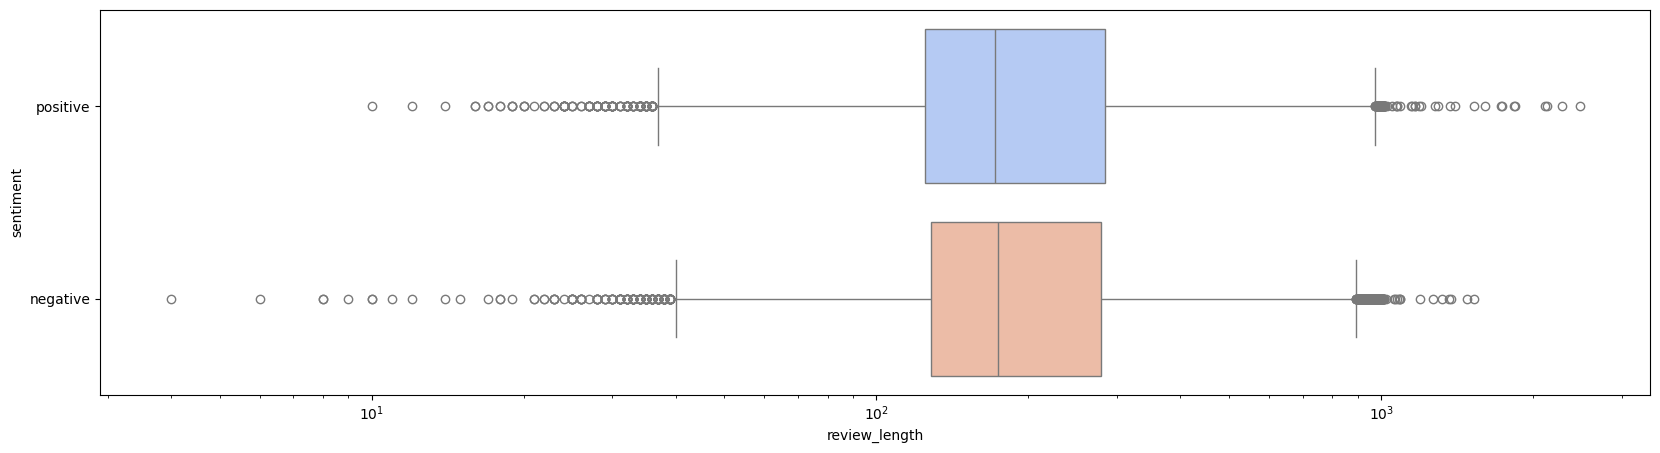

In [12]:
plt.figure(figsize = (20,5))
sns.boxplot(
    data = text_df_no_duplicates,
    x = text_df["review_length"],
    y = text_df["sentiment"],
    palette = "coolwarm",
    log_scale = True
)
plt.show()

### Text features

In [13]:
text_df_no_duplicates.head()

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


text has html tags

In [14]:
#define clean_text
def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)                   # Remove HTML tags
    text = re.sub(r"http\S+|www\S+", " ", text)          # Remove URLs
    text = re.sub(r"[^\x00-\x7F]+", " ", text)           # Remove non-ASCII
    text = re.sub(r"[_]+", " ", text)                    # Removes underscores
    text = re.sub(r"[^\w\s]", " ", text)                 # Remove punctuation/special chars
    text = re.sub(r"\s+", " ", text)                     # Normalize whitespace
    return text

In [15]:
#test clean_text function
print(clean_text(text_df_no_duplicates.iloc[0, 0]))

One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare Forget pretty 

In [16]:
# adding clean review column
text_df_no_duplicates["clean_review"] = text_df_no_duplicates["review"].apply(lambda x: clean_text(x))

In [17]:
# normalising the text data
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()
    # 2. Tokenization
    text = re.sub(r"[^\w\s+]", " ", text)
    tokens = nltk.word_tokenize(text)
    # 3. Stop Word Removal
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    # 4. Stemming/Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

In [18]:
# quick test
print(preprocess_text(text_df_no_duplicates.iloc[0, 0]))
print(text_df_no_duplicates.iloc[0, 3])
text_df_no_duplicates.columns

['one', 'reviewer', 'mentioned', 'watching', '1', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'br', 'br', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'br', 'br', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'br', 'br', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'painted', 'mainstream', 'audience', 'forget'

Index(['review', 'sentiment', 'review_length', 'clean_review'], dtype='object')

### Data Transformation

In [19]:
# encoding categorical variables
text_df_no_duplicates["label"] = text_df_no_duplicates["sentiment"].map({"positive" : 1, "negative" : 0})

# new data frame with labels and tokens
df = text_df_no_duplicates[["clean_review", "label"]]

# splitting data into training and testing sets
review_train, review_test, label_train, label_test = train_test_split(df["clean_review"], df["label"], test_size=0.2, random_state = 42)

## Feature extraction

In [102]:
# Create a TfidVectorizer object
vectorizer = TfidfVectorizer(#tokenizer = preprocess_text,
                             #lowercase = False,
                             min_df = 10,
                             ngram_range=(1,3),
                             max_features = 50000)

# Fit the vectorizer and tranform the reviews into a TF-IDF representation
train_vectors = vectorizer.fit_transform(review_train)
test_vectors = vectorizer.transform(review_test)

# print TF-IDF matrix shape
print(np.shape(train_vectors))
print(np.shape(test_vectors))

(39665, 50000)
(9917, 50000)


In [103]:
# print the vocabulary
print(vectorizer.get_feature_names_out()[:150])

['00' '000' '000 000' '007' '10' '10 000' '10 10' '10 and' '10 because'
 '10 but' '10 for' '10 for the' '10 from' '10 if' '10 is' '10 it'
 '10 lines' '10 minutes' '10 minutes of' '10 of' '10 on' '10 or' '10 out'
 '10 out of' '10 rating' '10 seconds' '10 stars' '10 the' '10 this'
 '10 times' '10 to' '10 year' '10 year old' '10 years' '10 years ago'
 '100' '100 minutes' '100 years' '1000' '101' '11' '11 year' '11 year old'
 '11 years' '12' '12 year' '12 year old' '12 years' '13' '13 year'
 '13 year old' '13th' '14' '14 year' '14 year old' '14 years' '15'
 '15 minutes' '15 minutes of' '15 year' '15 year old' '15 years' '150'
 '16' '16 year' '16 year old' '16mm' '17' '17 year' '17 year old'
 '17 years' '18' '180' '18th' '18th century' '19' '1920' '1920s' '1928'
 '1930' '1930s' '1931' '1932' '1933' '1934' '1935' '1936' '1937' '1938'
 '1939' '1940' '1940s' '1941' '1942' '1943' '1944' '1945' '1946' '1947'
 '1948' '1949' '1950' '1950s' '1951' '1952' '1953' '1954' '1955' '1956'
 '1957' '1958' '

## Training Model

### Logistic Regression

In [104]:
# Train Logistic Regression model as a baseline
lr = LogisticRegression()
lr.fit(train_vectors, label_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [105]:
# making predictions on the test set
predictions = lr.predict(test_vectors)

In [106]:
# Evaluating the model accuracy and f1 score
accuracy = accuracy_score(label_test, predictions)
f1 = f1_score(label_test, predictions)

print("Accuracy:", accuracy)
print("F1:", f1)

Accuracy: 0.9077341938086114
F1: 0.909199166418577


Confusion matrix
[[4421  518]
 [ 397 4581]]


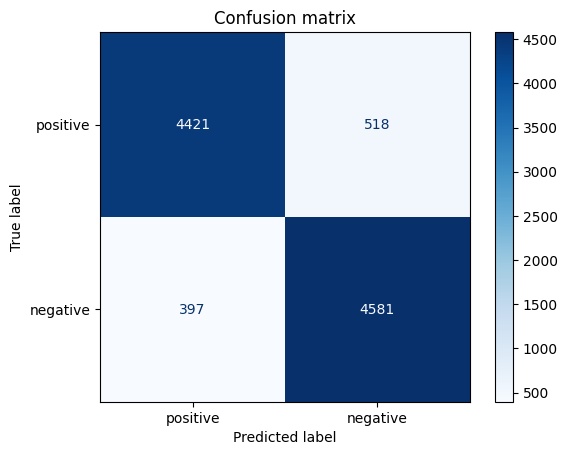

In [107]:
disp = ConfusionMatrixDisplay.from_estimator(
        lr,
        test_vectors,
        label_test,
        display_labels = text_df_no_duplicates.sentiment.unique(),
        cmap = plt.cm.Blues,
    )
disp.ax_.set_title("Confusion matrix")

print("Confusion matrix")
print(disp.confusion_matrix)

plt.show()

### Examining predictions

In [108]:
print(review_test.iloc[0])
print(label_test.iloc[0])

 Soul Plane is a horrible attempt at comedy that only should appeal people with thick skulls bloodshot eyes and furry pawns The plot is not only incoherent but also non existent acting is mostly sub sub par with a gang of highly moronic and dreadful characters thrown in for bad measure jokes are often spotted miles ahead and almost never even a bit amusing This movie lacks any structure and is full of racial stereotypes that must have seemed old even in the fifties the only thing it really has going for it is some pretty ladies but really if you want that you can rent something from the Adult section OK I can hardly see anything here to recommend since you ll probably have a lot a better and productive time chasing rats with a sledgehammer or inventing waterproof teabags or whatever 2 10
0


In [109]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(lr, train_vectors, feature_names=vectorizer.get_feature_names_out())   # Shap Explainer
shap_values = explainer(test_vectors)                # Compute SHAP values

In [110]:
def shapley_plot(index):
    shap.initjs()

    i = index

    # Get top 10 features by absolute SHAP value
    top_indices = np.argsort(np.abs(shap_values[i].values))[-10:]

    return shap.force_plot(
        shap_values[i].base_values,
        shap_values[i].values[top_indices],
        shap_values[i].data[top_indices],
        feature_names=vectorizer.get_feature_names_out()[top_indices]
    )

### Top Global Features 

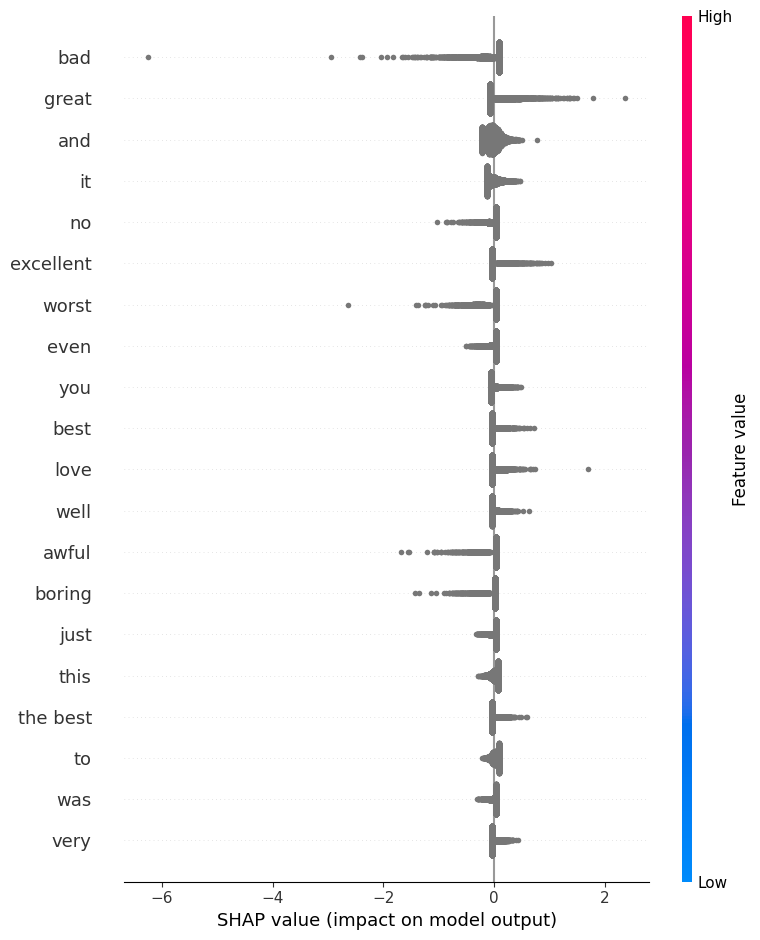

In [111]:
shap.summary_plot(shap_values, test_vectors, feature_names=vectorizer.get_feature_names_out())

### Analyse a wrong prediction

In [112]:
# Error analysis
count = 0

for idx, (pred, label) in enumerate(zip(predictions, label_test)):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(review_test.iloc[idx])
        count += 1
        if count == 5:
            break

Index: 2, Predicted: 1, Actual: 0
 National Treasure 2004 is a thoroughly misguided hodge podge of plot entanglements that borrow from nearly every cloak and dagger government conspiracy clich that has ever been written The film stars Nicholas Cage as Benjamin Franklin Gates how precious is that I ask you a seemingly normal fellow who for no other reason than being of a lineage of like minded misguided fortune hunters decides to steal a national treasure that has been hidden by the United States founding fathers After a bit of subtext and background that plays laughably unintentionally like Indiana Jones meets The Patriot the film degenerates into one misguided whimsy after another attempting to create a Stanley Goodspeed regurgitation of Nicholas Cage and launch the whole convoluted mess forward with a series of high octane but disconnected misadventures The relevancy and logic to having George Washington and his motley crew of patriots burying a king s ransom someplace on native soil

#### False positive

In [113]:
print(review_test.iloc[2])
print(f"Predicted: {predictions[2]}, Actual: {label_test.iloc[2]}")
shapley_plot(2)

 National Treasure 2004 is a thoroughly misguided hodge podge of plot entanglements that borrow from nearly every cloak and dagger government conspiracy clich that has ever been written The film stars Nicholas Cage as Benjamin Franklin Gates how precious is that I ask you a seemingly normal fellow who for no other reason than being of a lineage of like minded misguided fortune hunters decides to steal a national treasure that has been hidden by the United States founding fathers After a bit of subtext and background that plays laughably unintentionally like Indiana Jones meets The Patriot the film degenerates into one misguided whimsy after another attempting to create a Stanley Goodspeed regurgitation of Nicholas Cage and launch the whole convoluted mess forward with a series of high octane but disconnected misadventures The relevancy and logic to having George Washington and his motley crew of patriots burying a king s ransom someplace on native soil and then going through the meticu

#### False Negative

In [115]:
print(review_test.iloc[31])
print(f"Predicted: {predictions[31]}, Actual: {label_test.iloc[31]}")
shapley_plot(31)

Playwright John Osborne s Look Back in Anger The Entertainer dramatisation of Oscar Wilde s only novel positively revels in the homosexual subtext of the original perhaps too much so Nonetheless the dialogue the acting with a cast headed by Sir John Gielgud Jeremy Brett and the brilliantly cerebral production marred only by a too quick ending make this worth the while of any lover of Theater with a capital T 
Predicted: 0, Actual: 1


### BERT

In [116]:
# checking for GPU availability
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")

2.7.1+cu126
12.6
90701
NVIDIA GeForce RTX 3050 Ti Laptop GPU


#### Dataset prep

In [117]:
# creating the dataset
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset = dataset.rename_columns({
    "clean_review":"review"
})
print(dataset["train"][0])

{'review': 'I saw SEA OF DUST as part of a NYC screening audience several years ago I enjoyed the film at that time so I was a little confused by some of the amendments that had been made since Perhaps it s my memory but there seemed to be chunks of exposition missing from the version that was shown at the Rhode Island Film Festival I m really not sure which version I prefer but I can honestly say that I found something to appreciate it both Let me begin by warning everyone that this is not a popcorn movie Although it s been promoted as a Hammer Films tribute people expecting a showdown between Van Helsing and Dracula are going to be sorely disappointed There s some cleavage but no nudity a staple of the British production house s later movies And while SEA OF DUST is filled with gorgeous eye candy it really is shot like a sixties film and features Hammer starlet Ingrid Pitt it s not like any of the company s pictures in tone or execution This film is very dark very confusing and at ti

In [118]:
# initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

At first I am going to use the tokenizer with truncation and compare it with one that doesn't truncate the results.

In [119]:
# defining the tokenizer function
def tokenizer128(examples):
    return tokenizer(examples["review"], padding = "max_length", truncation = True, max_length = 128)
def tokenizer256(examples):
    return tokenizer(examples["review"], padding = "max_length", truncation = True, max_length = 256)
def tokenizer512(examples):
    return tokenizer(examples["review"], padding = "max_length", truncation = True)

In [120]:
# Apply the tokenizer to the dataset
dataset = dataset.map(tokenizer512, batched=True)
# Inspect tokenized samples
print(dataset["test"])

Map:   0%|          | 0/39665 [00:00<?, ? examples/s]

Map: 100%|██████████| 9917/9917 [00:02<00:00, 3992.23 examples/s]

Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 9917
})


#### Model selection and config

In [121]:
# initialize a Bert model for Binary classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

print(model.config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.53.2",
  "vocab_size": 30522
}



In [122]:
# Freeze all layers except the classifier
for param in model.distilbert.parameters():
    param.requires_grad = False
# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 592130


In [123]:
class CustomBERTModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask = None, labels = None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output[1])  # Applying dropout
        logits = self.fc(pooled_output)  # Adding a fully connected layer

        # If labels are provided, calculate loss
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Initialize the custom model
custom_model = CustomBERTModel("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Training Pipeline

In [124]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy= "epoch",    # Saving strategy to match eval_strategy
    learning_rate=5e-5,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=True                        # Enable mixed precision for faster training
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [125]:
# Load a metric (F1-score in this case)
metric = load("f1")

# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [126]:
# data collation for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [127]:
print(dataset["train"])

Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 39665
})


In [128]:
trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics     # Custom metric
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.368700,0.350137,0.850478
2,0.355400,0.337561,0.857056
3,0.341900,0.334258,0.857636


TrainOutput(global_step=7440, training_loss=0.36691488450573334, metrics={'train_runtime': 1199.6589, 'train_samples_per_second': 99.191, 'train_steps_per_second': 6.202, 'total_flos': 1.576295810307072e+16, 'train_loss': 0.36691488450573334, 'epoch': 3.0})

#### Evaluating model

In [129]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.3342576026916504, 'eval_f1': 0.8576364190631034, 'eval_runtime': 59.4883, 'eval_samples_per_second': 166.705, 'eval_steps_per_second': 10.422, 'epoch': 3.0}


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      5047
           1       0.85      0.87      0.86      4870

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



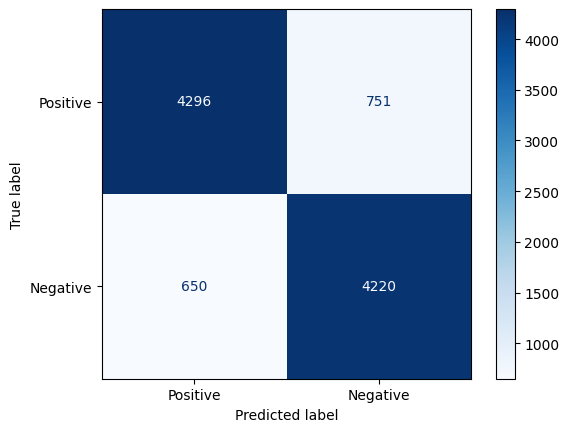

In [130]:
# Generate predictions
predictions = trainer.predict(dataset["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

# Classification report
print(classification_report(dataset["test"]["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(dataset["test"]["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot(cmap = "Blues")

Error Analysis

In [133]:
# Error analysis
count = 0

for idx, (pred, label) in enumerate(zip(predicted_labels, dataset["test"]["label"])):
    if pred != label:
        print(f"Index: {idx}, Predicted: {pred}, Actual: {label}")
        print(dataset["test"][idx]["review"])
        count += 1
        if count == 5:
            break

Index: 1, Predicted: 1, Actual: 0
I saw this movie when it first came to the theaters in 1988 and though I knew it wasn t of award winning caliber I kinda liked it It tales the tale of 5 former cub scouts reuniting to take on the one task they never got to finish as kids which is to climb Mt Whitehead Of course now the cub scouts are all grown up and have developed their personalities in a variety of ways but none too differently than they were as children Richard Lewis is still neurotic Richard Belzer is still a playboy Franklyn Ajaye is still sort of the Dear Abby of the group and Tim Thomerson is still the surfer dude of the group Of course the top billed star is Louie Anderson a true believer in everything Cub Scout related He still lives in the same house with his mother still goes over the Cub Scout manual daily is brave reverent and clean and is the one who reunites the others for one more grand adventure in Scouting Compounding their task however is the Grunski brothers two bul

In [136]:
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

explainer = shap.Explainer(pipe)

shap_values = explainer(dataset["test"]["review"][:5])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0])

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer: 6it [00:26,  5.27s/it]                       


#### Fine tuning